<h1 align='center'> Quora Insincere Questions Classification <h1>

<h2 align='right'> Euiyoung (Jim) Chung <h2>


## Descriptions:

In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

Has a non-neutral tone
Has an exaggerated tone to underscore a point about a group of people
Is rhetorical and meant to imply a statement about a group of people
Is disparaging or inflammatory
Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
Makes disparaging attacks/insults against a specific person or group of people
Based on an outlandish premise about a group of people
Disparages against a characteristic that is not fixable and not measurable
Isn't grounded in reality
Based on false information, or contains absurd assumptions
Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers
The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

**Data fields**<br>
qid - unique question identifier<br>
question_text - Quora question text<br>
target - a question labeled "insincere" has a value of 1, otherwise 0<br>


## Table of Contents:

1. Data Import 
2. Exploratory Data Analysis
3. Feature Engineering
4. Trying Multiple Model - Multiple Metrics - accuracy, recall, precision, f1 - based on learning curve I like ~ better.
5. Imbalance in Data - SMOTE
6. Fine-Tuning - f1-weighted, ROC curve, validation curve
7. Insights from the Models -> feature importance
8. Further - Error Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")

# data wrangling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text handling
from string import punctuation
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# ml
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, StratifiedKFold, 
                                        cross_val_score, learning_curve, validation_curve, cross_val_predict)
from sklearn.metrics import (make_scorer, confusion_matrix, accuracy_score,
                            precision_recall_fscore_support, f1_score, classification_report)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Imputer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD

# DL 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, LSTM, Dense

from tqdm import tqdm

plt.style.use('seaborn-whitegrid')
%matplotlib inline

<br>
## Data Import

In [2]:
ls

kensho_learn/   practice.ipynb  train.csv*


In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [5]:
df.shape

(1306122, 3)

In [6]:
df.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

In [7]:
df['target'].unique()

array([0, 1])

<br>
## Exploratory Data Anaylsis

In [8]:
# Examples of insincere texts
pd.options.display.max_colwidth = 100
df[df['target']==1].sample(10)

,qid,question_text,target
18364,0398852d05bed4f035d6,Why are gujaratis radical about their language and often behave rudely to outsiders?,1
893284,af03d05a013a040bc4ef,"What crime precipitated the Mueller investigation, or is this an investigation looking for a cri...",1
1059072,cf83f36e915655cac602,Why are programmers so arrogant and mock everyone who doesn't know about technology or computers...,1
1028847,c99d093a2f41854d2b3c,Should gays be removed to special camps?,1
466264,5b4dac3ed6a13f5170c2,Why do conservative scums want to bring forced military conscription?,1
1274623,f9cb76c56eed48a8f47d,When will US stop trying to conquer areas and leave them devastated?,1
1237801,f292d777cef27acd42fb,Why do Nepalese look like Chinese though Nepal is not a part of China?,1
496,00175f5e9c85b110614e,Why do Americans prefer just to not show up somewhere rather than face even the mildest of confl...,1
390406,4c79047872e5af6ec38c,How does the president prorogue and dissolve the US constitution and replace it with the Canadia...,1
1255063,f5f4c8b4a9a20573d33a,How can we destroy Israel?,1


In [9]:
# Examples of sincere texts
df[df['target']==0].sample(10)

,qid,question_text,target
235030,2dfa9d701956ea4cae28,"If the Illuminati know themselves that being gay is wrong, why does the world see it as a right ...",0
1131603,ddc6704cdff42be1d21c,What is the survival rate of a 35 week old fetus?,0
194615,260b91dfa43a0cc56a16,"What's the most relevant difference between Vietnamese, Cuban and Soviet socialism?",0
96293,12d6f36cb6cabffa19c9,What are some methods that could help fight depression?,0
757650,946f44751ba211cd9222,Is there a key to success?,0
864623,a9690f83a0af064b9f22,What pet name did someone give you that you hate(d)?,0
776872,982bcc170d55d8999770,"Is it possible that Super Commando Dhruva can recognise Chandika, that she is actually Shweta?",0
306589,3c0dbb336293af7d7f01,Will the new Russian SU-57 stealth bombers give the Russians an advantage over American backed f...,0
820598,a0cb332d4e04b2667622,Why are materialistic things loved more than people?,0
337276,421635d597e0d7664f00,What are the main subdivision of anatomy?,0


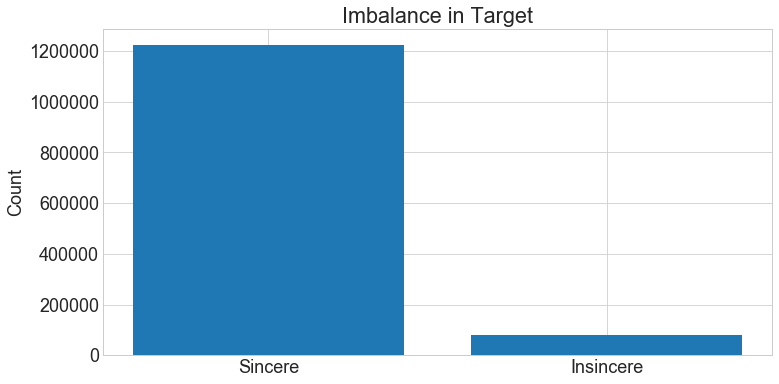

In [10]:
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 18
plt.bar(range(2), df['target'].value_counts())
plt.xticks(range(2), ["Sincere", "Insincere"])
plt.title('Imbalance in Target')
plt.ylabel('Count')
plt.show()

In [11]:
tf = TfidfVectorizer(lowercase=True, ngram_range=(1,1), stop_words='english')
tf_reg = TfidfVectorizer(lowercase=True, max_df=0.99, min_df=0.01,
                     ngram_range=(1,1), stop_words='english')

In [12]:
tf_vec = tf_reg.fit_transform(df['question_text'])

In [13]:
pd.DataFrame(tf_vec.toarray(), columns=tf_reg.get_feature_names)

TypeError: 'method' object is not iterable

In [ ]:
df['text_len'] = df['question_text'].map(len)
text_len_compare = df.groupby(['target'])['text_len'].mean()

plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 18
plt.bar(range(2), df.groupby(['target'])['text_len'].mean())
plt.xticks(range(2), ["Sincere", "Insincere"])
plt.title('Mean Length of Text')
plt.ylabel('Count')
plt.show()

In [ ]:
# Every ID is unique!
print("Is every ID unique? :", len(df['qid'].unique()) == df.shape[0])

<br>
## Feature Engineering

In [ ]:
df['text_len'] = df['question_text'].map(len)

In [ ]:
svd = TruncatedSVD(n_components=10, random_state=42)
col_names = ['pca {}'.format(i) for i in range(10)]
df_tf_idf = pd.DataFrame(svd.fit_transform(tf_vec_reg), columns=col_names)

In [ ]:
df_num = pd.concat([df, df_tf_idf], axis=1)

In [ ]:
X = df_num.drop(['qid', 'question_text', 'target'], axis=1).values

In [ ]:
y = df['target'].values

<br>
## Trying Multiple Models

## 1. No Cross-Validation: Bias & Variance Comparison between Models

** What is happening? **


** Approaches **

In [ ]:
oh = OneHotEncoder()
y_oh = oh.fit_transform(y.reshape(-1, 1))
y_label = y_oh.argmax(axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.2,
                                                    stratify=y_label, shuffle=True, random_state=42)

In [ ]:
short_X_train = X_train[:10**5, :5]
short_y_train = y_train[:10**5, :5]

In [ ]:
predictors = [KNeighborsClassifier(), LogisticRegression(), GaussianNB(), RandomForestClassifier(), 
              XGBClassifier(), SVC(decision_function_shape='ovo')]

short_predictors = [LogisticRegression(), XGBClassifier(), RandomForestClassifier()]

def simple_training_acc(preds, short_X_train, short_y_train, names=None):
    
    acc = {}
    
    for i, pred in tqdm(enumerate(preds)):
        prediction = pred.fit(X, y).predict(X)
        if names:
            acc[names[i]] = ((prediction == y).sum())/len(y)
        else:
            acc[i] = ((prediction == y).sum())/len(y)
            
    return acc
        
pred_names = ['kn', 'lr', 'nb', 'rf', 'xgb', 'svc']
short_pred_names = ['lr', 'rf', 'xgb']

acc = simple_training_acc(short_predictors, X_train, y_train, short_pred_names)

In [ ]:
for key, val in acc.items():
    print(f"{key} : {val}")

In [ ]:
plt.figure(figsize=(13, 5))
sns.barplot(short_pred_names, list(acc.values()))
plt.show()

<br>
## 2. Cross-Validation: Closer Look into Bias & Variance Trade-Off

** Differences **

** Accuracy metrics can be misleading **

In [ ]:
kfold = StratifiedKFold(n_splits=3)

acc_cross = {}
for i, pred in enumerate(short_predictors):
    acc_temp = cross_val_score(pred, short_X_train, np.array(short_y_train).ravel(), scoring='f1_micro', 
                               cv=kfold, n_jobs=-1)
    acc_cross['{}'.format(names[i])] = acc_temp.mean()
    

In [ ]:
for key, val in acc_cross.items():
    print(f"{key} : {val}")

In [ ]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(14, 5))
sns.barplot(short_pred_names, list(acc_cross.values()))
plt.show()

<br>
## 3. Learning Curve - Performance vs. Number of Training Samples

** Approaches **

** Findings **

In [ ]:
def call_plot(xaxis, train_scores, test_scores, name_pred, name_param):
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    train_scores_std = train_scores.std(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    plt.rcParams['font.size'] = 12
    plt.figure(figsize=(10,4))
    plt.plot(xaxis, train_scores_mean, label='Train score')
    plt.plot(xaxis, test_scores_mean, label='Test score')
    plt.fill_between(xaxis, train_scores_mean - 3*train_scores_std,
                train_scores_mean + 3*train_scores_std, alpha=0.15)
    plt.fill_between(xaxis, test_scores_mean - 3*test_scores_std,
                test_scores_mean + 3*test_scores_std, alpha=0.15)
    plt.legend(fontsize=14)
    plt.xlabel(name_param)
    plt.ylabel('Accuracy')
    plt.title("{} Accuracy vs. {}".format(name_pred, name_param))
    plt.show()
    
def plot_learning_curve(predictor, X, y, name_param, name_pred, cv=3):
    train_sizes, train_scores, test_scores = learning_curve(predictor, X, y, cv=cv, scoring='f1_weighted')
    call_plot(train_sizes, train_scores, test_scores, name_pred, name_param)
    
plot_learning_curve(RandomForestClassifier(), short_X_train, short_y_train, "Training Samples", "Random Forest")

In [ ]:
# I could not finish executing this function due to the time consumption
# It generates multiple learning curves for each classifier.
# That gives us deep understanding of bias & variance proportions of the algorithms
def plot_multiple_learning_curve(pred, X, y, name, cv=3)

<br>
## 4. Validation Curve - Performance vs. Regularization Parameter

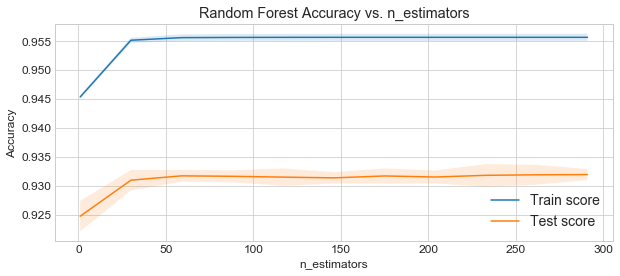

In [66]:
def plot_val_curve(predictor, X, y, name_param, name_pred, param_space, cv=3):
    train_scores, test_scores = validation_curve(predictor, X, y, name_param,
                                               param_space, cv=cv)
    call_plot(param_space, train_scores, test_scores, name_pred, name_param)
    
plot_val_curve(RandomForestClassifier(), short_X_train, short_y_train, 'n_estimators',
               'Random Forest', range(1, 300, 29))

### 5. Multi-Class ROC Curve - How about the imbalance of the data?

** Approaches **
- a
- b
- c

In [79]:
# ROC curve for multi-class -> make a library
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [80]:
# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [81]:
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

In [82]:
# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

In [83]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

In [84]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [85]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [ ]:
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [ ]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


In [ ]:
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

<br>
## Hyperparameter Tuning - Random Search


In [185]:
# Hyperparameter grid
rf_param_grid = {
    'n_estimators': np.linspace(10, 100).astype(int),
    'max_depth': [None] + list(np.linspace(5, 30).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier()
rf_rs = RandomizedSearchCV(rf, rf_param_grid, n_jobs = -1, 
                        scoring = 'f1_weighted', cv = kfold, 
                        n_iter = 10, verbose = 1)
rf_rs.fit(short_X_train, short_y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.1s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([ 10,  11,  13,  15,  17,  19,  21,  22,  24,  26,  28,  30,  32,
        33,  35,  37,  39,  41,  43,  44,  46,  48,  50,  52,  54,  55,
        57,  59,  61,  63,  65,  66,  68,  70,  72,  74,  76,  77,  79,
        81,  83,  85,  87,  88,  90,  92,  94, ... 49, 50], 'min_samples_split': [2, 5, 10], 'boots

In [87]:
# A parameter grid for XGBoost
xg_param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xg = XGBClassifier()
xg_rs = RandomizedSearchCV(xg, xg_param_grid, 
                                   n_iter=100, scoring='f1_micro', 
                                   n_jobs=-1, cv=kfold, verbose=3)
xg_rs.fit(short_X_train, np.array(short_y_train).ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_micro', verbose=3)

## Test

In [157]:
clf = rf_rs.best_estimator_

In [193]:
pd.DataFrame(rf_rs.cv_results_).sort_values('mean_test_score', ascending=False)[['param_n_estimators', 'mean_test_score']]

,param_n_estimators,mean_test_score
3,83,0.824644
1,35,0.823960
0,81,0.823056
4,94,0.821957
5,19,0.821733
8,44,0.820834
9,77,0.820022
2,28,0.817563
6,100,0.813282
7,19,0.813178


In [158]:
pred = clf.predict(X_test[:,:5])

In [159]:
print(classification_report(np.asarray(y_test).ravel(), pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85    245063
           1       0.14      0.60      0.23     16162

   micro avg       0.75      0.75      0.75    261225
   macro avg       0.55      0.68      0.54    261225
weighted avg       0.92      0.75      0.81    261225

